# Synthetic Data Generation Strategy 5: Upsampling selected KEGG Pathways *with* Ludwig's Covariance sampler


## Outline:

1.  Get means/variances from empirical data
2.  Use SVD trick from Ludwig to sample new 'regular' points.
3.  Get pathway genes from KEGG
4.  Resample the means for nodes in the pathway ("dysregulate" a subset of those nodes)
5.  Use SVD trick to sample new 'dysregulated' points.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import pickle as pkl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


# 1. Get means and variances of empirical data

Let's use the Ovarian cancer data since it's nicely compact. We'll use the Experimental InBioMap PPI. 

In [2]:
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)

ovarian.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
PNNL-TCGA-09-1664,0.0,-0.119,-0.1880,0.5710,-0.224000,0.3320,0.0,-0.2160,0.205,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1484,0.0,0.000,-0.1210,-1.4500,0.079000,0.1030,0.0,-0.9750,0.000,0.175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1488,0.0,0.000,-0.2190,-0.0765,-1.340000,-0.4200,0.0,0.0158,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1489,0.0,0.000,0.2360,0.7490,0.107000,-0.0168,0.0,-0.1470,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1494,0.0,0.433,0.0158,-0.2100,0.000859,-0.5270,0.0,0.0926,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
means = ovarian.mean(axis=0)
variances = ovarian.var(axis=0)

# 2. Sample negative examples

## 2.1 Apply a standard scaling
We don't do this anymore, it's bundled into  Ludwig's covariance sampler.

## 2.2 Ludwig's Covariance Sampler

In [4]:
# data is n x d, where n is the number of samples and d the dimension
def sample_cov(number_of_samples_desired, data):
    n, d = data.shape
    mean = np.mean(data, axis=0)
    _, S, V = np.linalg.svd((data - mean) / math.sqrt(n), full_matrices=False)
    randomness = np.random.randn(number_of_samples_desired, min(n, d))
    return np.dot(randomness, np.dot(np.diag(S), V))

## 2.3 Sample from the same distribution as the input (we call these "negatives")

In [5]:
negatives = sample_cov(100, ovarian)
negatives = np.around(negatives + means.values, 6)
negatives = pd.DataFrame(negatives, columns=ovarian.columns, index=['negative']*100)
negatives.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
negative,-0.0,-0.027707,-0.241953,-0.791363,-0.250398,-0.020193,-0.0,-0.741158,-0.234180,0.139104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.074602,-0.258861,0.041920,-0.855773,0.026916,-0.0,-0.120745,-0.009547,0.231819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,0.587159,0.351837,1.271397,-0.119095,-0.565970,0.0,0.039232,-0.428672,0.092480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.201352,-0.101680,-1.160840,1.054695,0.520418,0.0,-0.180909,0.572704,-0.878204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.113378,-0.464057,-0.676378,-0.583622,0.006282,-0.0,0.035001,0.560040,-0.056646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Retrieve KEGG pathways we'd like to "dysregulate" for our positive sets

(pathways downloaded and normalized in sibling notebook)

## 3.1 Load pathways dataframe

In [7]:
pathways = pd.read_pickle('/Users/alex/Documents/proteomics/synthetic_proteomics/data_generation/KEGG_df.pickle')
pathways.head()

genes  \
class              subclass               id                                                            
Cellular Processes  Cell growth and death hsa04110  [CCND1, CCND2, CCND3, CDK4, CDK6, RB1, RBL1, R...   
                                          hsa04114  [INS, IGF1, IGF1R, PGR, AR, ADCY1, ADCY2, ADCY...   
                                          hsa04115  [ATM, CHEK2, ATR, CHEK1, GORAB, CDKN2A, MDM2, ...   
                                          hsa04210  [TNFSF10, TNFRSF10A, TNFRSF10B, TNFRSF10C, TNF...   
                                          hsa04215  [TNFRSF1A, FADD, CASP8, CASP7, CASP3, BID, BCL...   

                                                                            name  
class              subclass               id                                      
Cellular Processes  Cell growth and death hsa04110                    Cell cycle  
                                          hsa04114                Oocyte meiosis  
                                          hsa04115         p53 signaling pathway  
                                          hsa04210                     Apoptosis  
                                          hsa04215  Apoptosis - multiple species

In [8]:
np.unique(pathways.index.get_level_values(0))

array(['Cellular Processes', 'Environmental Information Processing',
       'Genetic Information Processing', 'Human Diseases', 'Metabolism',
       'Organismal Systems'], dtype=object)

## 3.2 Remove metabolic pathways

In [9]:
pathways = pathways.drop('Metabolism', level=0)

In [10]:
np.unique(pathways.index.get_level_values(0))

array(['Cellular Processes', 'Environmental Information Processing',
       'Genetic Information Processing', 'Human Diseases',
       'Organismal Systems'], dtype=object)

# 4. Update the pathway means by resampling.

In [12]:
pathway_id = "hsa04110"
pathway_genes = pathways.loc[pd.IndexSlice[:,:,[pathway_id]], ['genes']].values[0][0]

In [13]:
new_pathway_means = pd.Series(np.random.normal(0,variances), index=variances.index)[pathway_genes].fillna(0)
new_means = pd.concat([means, new_pathway_means], axis=1).fillna(0).sum(axis=1).reindex(means.index)
new_means.head()

ZNF91     0.000000
NDEL1     0.010325
ELAVL1    0.031412
SUMO1     0.126737
SUMO3    -0.039357
dtype: float64

# 5. Sample positive examples

In [14]:
positives = sample_cov(100, ovarian)
positives = np.around(positives + new_means.values, 6)
positives = pd.DataFrame(positives, columns=ovarian.columns, index=[pathway_id]*100)
positives.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,-0.0,0.289412,-0.255266,-0.224572,-0.834915,0.157898,0.0,-0.035655,0.548856,-0.121948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,0.015679,0.033530,-0.005626,0.105907,0.413857,-0.0,-0.520199,1.327620,-0.576041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.047103,0.093755,-0.264099,-0.772337,0.093963,-0.0,-0.086158,0.651008,-0.665216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,0.0,0.034222,0.022828,0.507435,1.062884,0.469328,-0.0,0.025344,1.456044,-0.149424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,0.0,0.095778,-0.053393,-0.158899,0.696211,-0.261009,-0.0,-0.263787,0.063522,0.626228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
ovarian.index = ['true'] * len(ovarian)

In [16]:
dataset = pd.concat([ovarian, positives, negatives])
y = dataset.index.values

PC 1: 8.49%   PC 2: 4.41%   


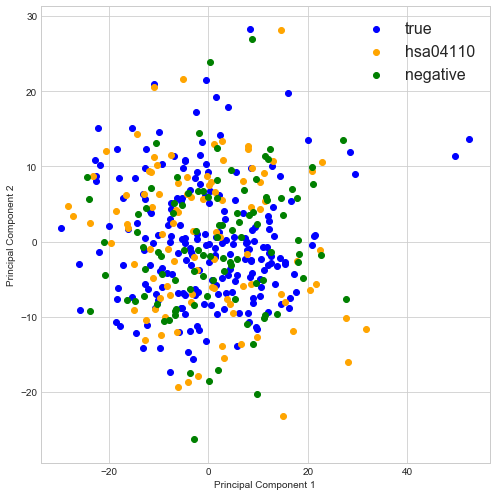

In [17]:
pca = PCA(n_components=2)
Y = pca.fit_transform(dataset)

with plt.style.context('seaborn-whitegrid'):
    figure(figsize=(7, 7))
    for label, color in zip(('true','hsa04110', 'negative'), ('blue','orange', 'green')):
        plt.scatter(Y[y==label, 0], Y[y==label, 1], label=label, c=color)
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right',prop={'size':16})
    plt.tight_layout()
    print(''.join(['PC '+str(i+1)+': '+str(var*100)[:4]+'%   ' for i, var in enumerate(pca.explained_variance_ratio_)]))
    plt.show()

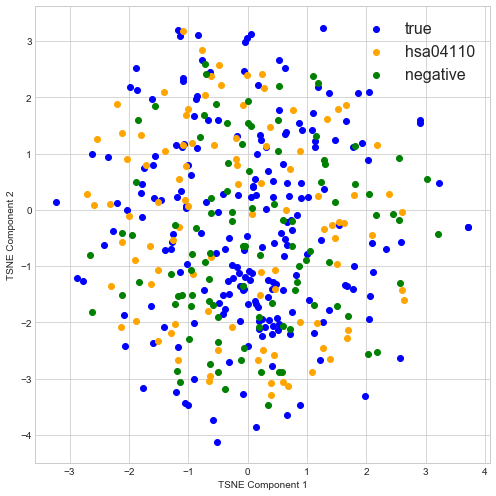

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=100, perplexity=100)
Y = tsne.fit_transform(dataset)

with plt.style.context('seaborn-whitegrid'):
    figure(figsize=(7, 7))
    for label, color in zip(('true','hsa04110', 'negative'), ('blue','orange', 'green')):
        plt.scatter(Y[y==label, 0], Y[y==label, 1], label=label, c=color)
        
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(loc='upper right',prop={'size':16})
    plt.tight_layout()
    plt.show()